# Implementation using Resnet50 de TensorFlow

In [1]:
! git clone https://github.com/kumquat42/ProjetFinal_JedhaDS27_Emotions.git

Cloning into 'ProjetFinal_JedhaDS27_Emotions'...
remote: Enumerating objects: 34152, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 34152 (delta 0), reused 2 (delta 0), pack-reused 34149
Receiving objects: 100% (34152/34152), 138.90 MiB | 29.21 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (35890/35890), done.


In [92]:
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib

import tensorflow as tf
# from pathlib import Path
tf.__version__
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Importation Images

- Data augmentation for train only
-

In [52]:
train_dir = "/content/ProjetFinal_JedhaDS27_Emotions/Datasets/FER2013/train"
test_dir = "/content/ProjetFinal_JedhaDS27_Emotions/Datasets/FER2013/test"

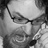

In [53]:
with Image.open(f'{test_dir}/angry/PrivateTest_10131363.jpg') as img:
#with Image.open(f'{train_dir}/angry/Training_10118481.jpg') as img:
  display(img)


In [ ]:
# Parameters

BATCH_SIZE = 64

FINE_TUNING = 30

EARLY_STOPPING_CRITERIA = 3
EPOCHS = 30


#  A travailler
CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] # A faire
class_weight = {0: 1.,
                1: 50.,
                2: 2.} # -> A faire


In [102]:
# Data augmentation to add a few weird stuffs for the train only
train_datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,   # Randomly shift the height of images by up to 10%
    brightness_range=(0.5, 1),
    rescale = 1./255,
    validation_split = 0.3
)

train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",     #grayscale
    class_mode = "categorical",
    shuffle=True,
    subset="training"
)

# Validation_set à partir du test_set
validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

validation_generator = validation_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle=True,
    subset="validation"

)

# Found 28709 images belonging to 7 classes. To update
# Found 7178 images belonging to 7 classes. To update


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
'''
Not tested yet
# voir les images - à tester...
imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(img_generator_flow_train.labels == tf.argmax(label)) # Je cherche n'importe quelle index avec une valeur True
  true_label_name = Path(img_generator_flow_train.filepaths[true_file_path]).parent.name
  plt.imshow(img)
  plt.title(true_label_name)
  plt.show()
'''

In [ ]:
'''
Useless for now


# with Image.open('/home/melb/Documents/Projects/Projet final/ProjetFinal_JedhaDS27_Emotions/FER2013/train/angry/Training_8521861.jpg') as im:
#        im.show()

array_rgb = np.array(im.convert(mode = 'RGB')).reshape(48,48,3) # ValueError: cannot reshape array of size 2304 into shape (48,48,3)
# im_rgb = Image.fromarray(array_rgb)
# im_rgb.show()

'''

# models

Import du modèle resnet avec les poids Imagenet

resnet_model_1 :
- Données : 28709 images (train), val 7178 imags (test)
- Batch 64
- Poids du modèle Imagenet. Je unfreeze la dernière couche
- Paramètres:
 input_[(None, 48, 48, 3)]
 output (None, 2, 2, 2048)    

Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)

class_res_1:  
Réentrainement seulement sur la dernière couche + en dense 7  
Paramètres:
Total params: 23602055 (90.03 MB)
Trainable params: 14343 (56.03 KB)
Non-trainable params: 23587712 (89.98 MB)
his_res_1

Résultats pourris

class_res_30:
Réentrainement seulement sur les 30 dernières couches + en dense 7  

Total params: 23602055 (90.03 MB)
Trainable params: 14464519 (55.18 MB)
Non-trainable params: 9137536 (34.86 MB)


In [58]:
resnet_model_1 = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3), # ne fonctionne pas avec 48, 48, 1 car les images sont censées être en couleur...
                                               include_top=False,
                                               weights = "imagenet"
                                               )

resnet_model_1.trainable = False


In [ ]:
print(len(resnet_model_1.layers)) # 175
resnet_model_1.summary()

In [ ]:
tf.keras.utils.plot_model(resnet_model_1, show_shapes=True)

In [104]:
# Class_res_1 : on ré-entraine (30) dernière layer:
resnet_model_1.trainable = True

fine_tune_at = len(resnet_model_1.layers) - FINE_TUNING

for layer in resnet_model_1.layers[:fine_tune_at]:
  layer.trainable = False

# ajout de la couche dense:
class_res_30 = tf.keras.Sequential([
    resnet_model_1,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation="softmax")
  ])

class_res_30.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d_4 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 14464519 (55.18 MB)
Non-trainable params: 9137536 (34.86 MB)
_________________________________________________________________


In [105]:
class_res_30.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # n s'arrête quand la loss est au plateau
                                                         patience= EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = class_res_30.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator ,
                    callbacks= [earlyStoppingCallback],
                    class_weight=class_weight)

his_res_1 = pd.DataFrame(history.history)



In [ ]:
plt.plot(his_res_1["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(his_res_1["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [ ]:
plt.plot(his_res_1["loss"], c="r", label="train_loss")
plt.plot(his_res_1["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [95]:
class_res_1.save("/content/ProjetFinal_JedhaDS27_Emotions/class_res_1.h5")
his_res_1.to_csv('/content/ProjetFinal_JedhaDS27_Emotions/his_res_1.csv')

In [ ]:
his_res_1.head()

# A travailler au plus vite

# Classweight

In [ ]:
Grégory

Scaling by total/2 helps keep the loss to a similar magnitude.
The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


 — 
Aujourd’hui à 14:49
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

print(img_generator_flow_train.labels)

# GRAD CAM

In [ ]:
# GradCam
 Create an object `imgs` and an object `labels` containing a batch of validation images and validation labels.
imgs, labels = next(iter(img_generator_flow_valid))


2. Get the name of the last convolution layer of the pretrained model and the predicition layers and store them in two variables called respectively `last_conv_layer_name`, and `classifier_layer_names`.
for layer in model.layers:
  print(layer.name)

base_model = model.layers[0]

last_conv_layer_name = "mixed10"
classifier_layer_names = [layer.name for layer in model.layers][1:]

3. Run the following command, these functions will help you produce the grad cam

# We start by setting up the dependencies we will use

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


4. Create a `preds` object containing the predicitons from your model on the batch of validation images.

Then create a `pred_labels` object containing the top class predicted for each image in that batch. (You can use the `tf.argmax` function for this)

# Print what the top predicted class is
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

print("Prediction output:", preds)

print("Predicted label:", pred_labels)

# Generate class activation heatmap
heatmaps = []

for img in imgs:
  heatmap = make_gradcam_heatmap(
    tf.expand_dims(img,axis=0),base_model, model, last_conv_layer_name, classifier_layer_names
  )
  heatmaps.append(heatmap)


# Display heatmap
plt.matshow(heatmaps[0])
plt.show()


6. Loop over each image, predicted label and heatmap in order to display the images with the superimposed grad cam heatmap and the corresponding predicted label. Do they match the true label? What happens to the grad cam for wrong predictions? Are there any grad cams that seem surprising to you?

from pathlib import Path

for img, pred_label, true_label, heatmap in zip(imgs, pred_labels, labels, heatmaps):
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.003 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "saved_img.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  pred_file_path = np.argmax(img_generator_flow_valid.labels == pred_label)
  pred_label_name = Path(img_generator_flow_valid.filepaths[pred_file_path]).parent.name

  true_file_path = np.argmax(img_generator_flow_valid.labels == tf.argmax(true_label))
  true_label_name = Path(img_generator_flow_valid.filepaths[true_file_path]).parent.name

  print("Predicted label:",pred_label_name)
  print("True label:", true_label_name)

  display(Image(save_path))
